#### 1. 필요 모듈 불러오기

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### 2. CUDA 사용 여부 확인

In [3]:
print(torch.cuda.is_available())

True


#### 3. CNN 모델 만들어보기

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 모델 생성을 위한 Sequential 사용
model = nn.Sequential(
    # 첫 번째 컨볼루션 레이어
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 두 번째 컨볼루션 레이어
    nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flatten 레이어 (nn.Flatten을 사용하여 데이터를 1차원으로 만듦)
    nn.Flatten(),
    # 완전 연결 레이어
    nn.Linear(32 * 7 * 7, 120),
    nn.ReLU(),
    nn.Linear(120, 10)
)

print(model)


Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=10, bias=True)
)


#### 4. 모델 구조 시각화해서 확인해보기

In [ ]:
!pip install torchvize

In [ ]:
!conda install graphvize # 설치 후 다시 시작

In [7]:
from torchviz import make_dot

# 가상의 입력 데이터 생성 (예: 1개의 28x28 크기의 흑백 이미지)
inputs = torch.randn(1, 1, 28, 28)

# 모델을 통해 입력 데이터 전달
outputs = model(inputs)

# make_dot 함수를 사용해 모델의 연산 그래프 생성 및 시각화
dot = make_dot(outputs, params=dict(model.named_parameters()))

# 연산 그래프를 png 파일로 저장
dot.render('model_graph', format='png')

'model_graph.png'

### 5. 모델 학습시켜보기

#### 1-1. 데이터 셋 준비

In [8]:
import torch
from torchvision import datasets, transforms

# 데이터셋을 로드하기 전에 적용할 전처리를 정의합니다.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 학습 데이터셋
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 테스트 데이터셋
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



#### 1-2. 데이터셋 확인

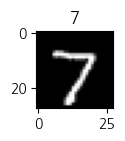

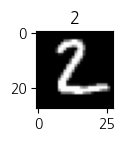

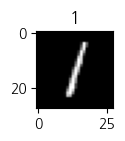

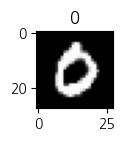

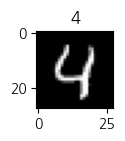

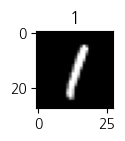

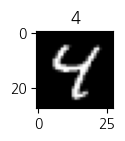

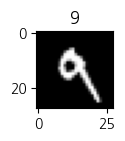

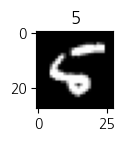

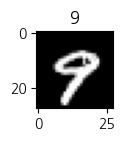

In [21]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

for x in range(10):
    images, labels = next(iter(test_loader))
    plt.figure(figsize=(2,1))
    plt.imshow(images[x].squeeze(), cmap='gray')
    plt.title(f'{labels[x].item()}')
    plt.show()

#### 2. 손실함수와 옵티마이저 설정

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3. 모델 학습

In [11]:
num_epochs = 10
for epoch in range(num_epochs):  # 학습 데이터셋을 여러 번 반복합니다.
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # 그래디언트 버퍼를 0으로 초기화
        outputs = model(inputs)  # 순전파
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파, 그래디언트 계산
        optimizer.step()  # 파라미터 업데이트

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.019524723291397095
Epoch 2, Loss: 0.03265826776623726
Epoch 3, Loss: 0.09123627096414566
Epoch 4, Loss: 0.024704037234187126
Epoch 5, Loss: 0.053091343492269516
Epoch 6, Loss: 0.0002735368616413325
Epoch 7, Loss: 0.0004032333963550627
Epoch 8, Loss: 0.004965689033269882
Epoch 9, Loss: 0.00025033706333488226
Epoch 10, Loss: 0.00020777010649908334


#### 4. 모델 평가

In [12]:
model.eval()  # 평가 모드로 전환
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'모델의 정확도 계산: {100 * correct / total} %')

모델의 정확도 계산: 98.89 %


#### 5. 테스트 이미지 확인

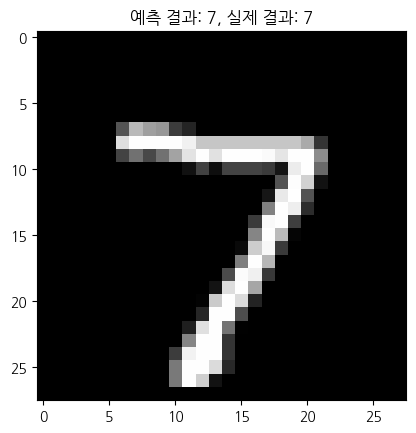

In [15]:
images, labels = next(iter(test_loader))
with torch.no_grad():
    logits = model(images[0].unsqueeze(0)) # 첫 번째 이미지에 대한 모델의 출력을 얻습니다.
    predicted_label = torch.argmax(logits, dim=1)
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f'예측 결과: {predicted_label.item()}, 실제 결과: {labels[0].item()}')
plt.show()